# Analysing github repository data to predict the most popular topics which are being discussed on github

##### Case: we have a csv containing some github data about repositories created in the year 2022. The data contains information such as the repo name, owner, the topics they about, the number of issues, PRs and forks each topic has. I want to figure out, via a classification algorithm which  topic is the most "saught out" topic on github in the year of 2022, and use the model to predict future trends on what the next saught out topic will be.


### Things to keep in mind before implementing the model:
<ul>
<li>What do we mean by saught after?</li>
<li>What are some potential weaknesses that can cause the model to create an inaccurate represnetation of the future trends on github?</li>

</ul>


##### By "saught after" we mean repositories on github taht have received the most ammount of stars and forks, as those taken together are usually good indicators of a repos popularity: a repo that has both not only has been starred (so liked) by the general public but is so appreciated that people have been willing to save a copy of it in their account, wehter that is for safekeeping for the future, or because they are so invested in the project taht tehy would like to contribute to it and as such have forked it to later submit a PR.

##### The way topics are represented in this dataset is by specificity.  If we have a project with the "React" topic, it will belong to a different topic than a project with the  "Javsascript" topic , despite the two share teh same undelrying technology, and have a lot of overlap. 
##### Because our model will not take into account that many topics overlap, it might in the long run inaccurately predict popular trends. (It might say for ex, that "React" is the most saught after topic, whereas Javascript is wildy unpopular. This would arguably be a misreprensetation of data as because in order to create the saught after repositories (ones using React) one needs to know Javascript quite proffiviently, hence also Javascript in general is likely to be a saught after skill/topic. )

# Section 1:visualising and preprocessing the data

In [26]:

#install any relevant imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

##### Load the csv and inspect its contents:


In [27]:
#load the csv and inspect its contents
df = pd.read_csv("github.csv")
df.head()

,Username,Repo_name,Stars,Url,Issues,Pull_Requests,Forks,Topics
0,mrdoob,three.js,7900,https://github.com/mrdoob/three.js,338.0,138,30600,3D
1,libgdx,libgdx,19600,https://github.com/libgdx/libgdx,164.0,61,6300,3D
2,pmndrs,react-three-fiber,16800,https://github.com/pmndrs/react-three-fiber,18.0,4,908,3D
3,BabylonJS,Babylon.js,15900,https://github.com/BabylonJS/Babylon.js,72.0,11,2700,3D
4,aframevr,aframe,13800,https://github.com/aframevr/aframe,310.0,39,3300,3D


##### Load the csv and inspect its contents:


In [28]:
df.isnull().values.any()
df.isnull().sum().sum()

26

##### Here we have 26 missing values.#there are various ways to deal with missing values, as there is a small sample here, I am just going to delete the rows in a df where there are missing values


In [29]:
df.dropna(inplace=True)

##### We will also drop the columns containing information on the repo name, title. owner and url. They are irrelevant for our analysis.

In [30]:
df.drop(["Username", "Repo_name", "Url"], axis=1,inplace=True)
df.head()

,Stars,Issues,Pull_Requests,Forks,Topics
0,7900,338.0,138,30600,3D
1,19600,164.0,61,6300,3D
2,16800,18.0,4,908,3D
3,15900,72.0,11,2700,3D
4,13800,310.0,39,3300,3D


##### We are going to predict the trending topics with this csv. To do this let's get an idea of what the unique topics are first. Running the code below will tell us that we have 30 uique topics in this repo and will output an array of the unique values:


In [51]:
print(df['Topics'].nunique())
print(df['Topics'].unique())

30
['3D' 'Ajax' 'Algorithm' 'Amp' 'Android' 'Angular' 'Ansible' 'API'
 'Arduino' 'ASP.NET' 'Atom' 'Awesome Lists' 'Amazon Web Services' 'Azure'
 'Babel' 'Bash' 'Bitcoin' 'Bootstrap' 'Bot' 'C' 'Chrome'
 'Chrome extension' 'Command line interface' 'Clojure' 'Code quality'
 'Code review' 'Compiler' 'Continuous integration' 'COVID-19' 'C++']


##### visuals are always good, so let's see what are the most frequent topics in this dataset.here we have a bar diagram of the topics


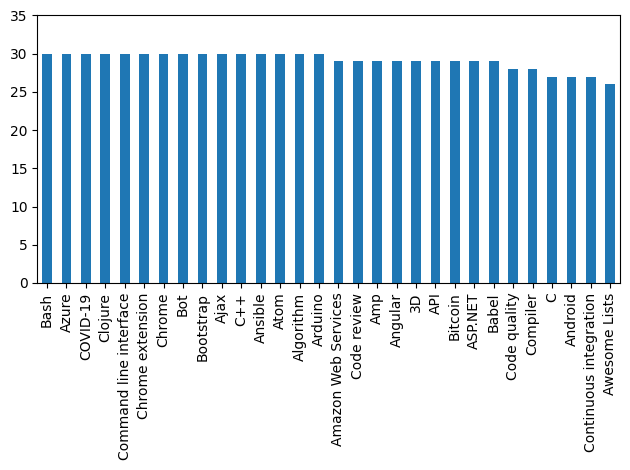

In [32]:
df['Topics'].value_counts().plot(kind='bar')
plt.ylim(0, 35)
plt.xticks(rotation=90)

plt.tight_layout()

#### the most frequent topics in this repositroy seem the ones rranging from Bash to Arduino. 
#### But are they teh most starred and forked? Is there a correlation betwen the number of forks and stars? I suspect there is, but let's plot a scatterplot to verify this:


Text(0.5, 1.0, 'Number of Forks vs Number of Stars Graph Raw Data')

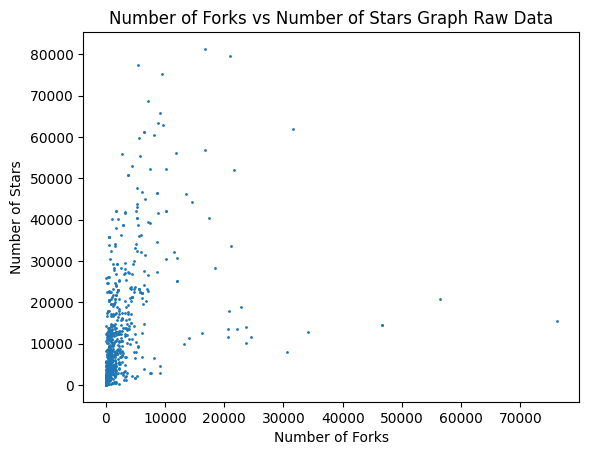

In [33]:


plt.scatter(df["Forks"], df["Stars"], s=1)
plt.xlabel("Number of Forks")
plt.ylabel("Number of Stars")

plt.title("Number of Forks vs Number of Stars Graph Raw Data")


#### Although there does seem to be a psotiive correlation between the number of forks and the number of stars, but the scatterplot  also tells us that there are quite a few outliers in this dataset, signifying to us that we need to clean this data a bit more before feeding it into our model.
#### Past over 15000 forks we tend to have outliers, (many forks nut not that many stars) so let's go ahead and remove this outlier data from the dataframe.



In [34]:
first_clean_df = df[(df['Forks'] <= 15000)]

##### Now that the outlier data has been removed let's have a look at the scatterplot again

Text(0.5, 1.0, 'Number of Forks vs Number of Stars Graph First cleaned Data')

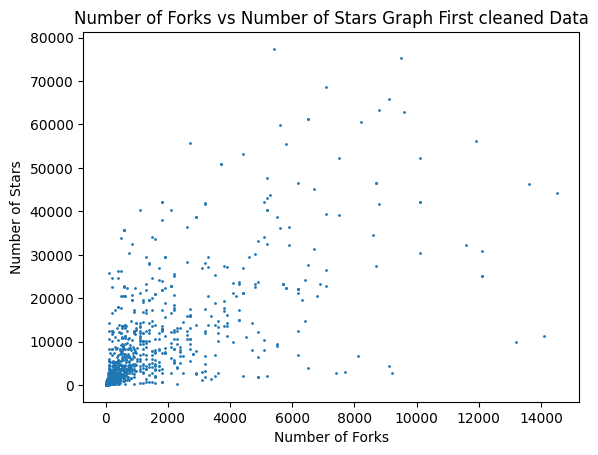

In [35]:
plt.scatter(first_clean_df["Forks"], first_clean_df["Stars"], s=1)
plt.xlabel("Number of Forks")
plt.ylabel("Number of Stars")

plt.title("Number of Forks vs Number of Stars Graph First cleaned Data")


#### let's visualise this correlation with a heatmap:

C:\Users\amilc\AppData\Local\Temp\ipykernel_23832\2252081300.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = first_clean_df.corr()


<AxesSubplot: >

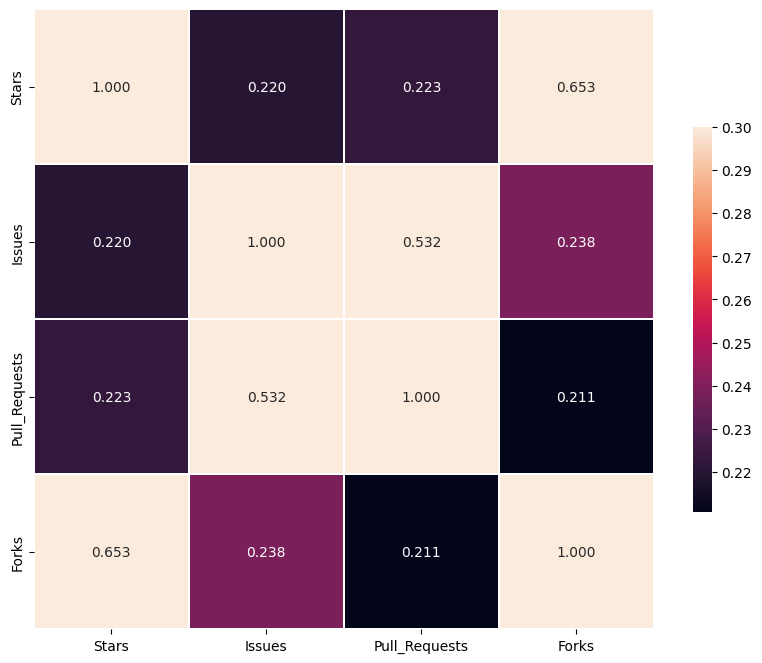

In [36]:
corr = first_clean_df.corr()


fig, ax = plt.subplots(figsize=(10,10))


sns.heatmap(corr,  vmax=0.3, square=True, cbar_kws={'shrink':0.5}, fmt='.3f', linewidths='0.05', annot=True)


###### #as exoected there is a strong correlation (06.49) between the number of forks an the number of stars. There is also a strong correlation between the number of issues and the number of pull requests (0.532)

#### Now let's figure out which of the topics gets the most stars (through a bar chart)

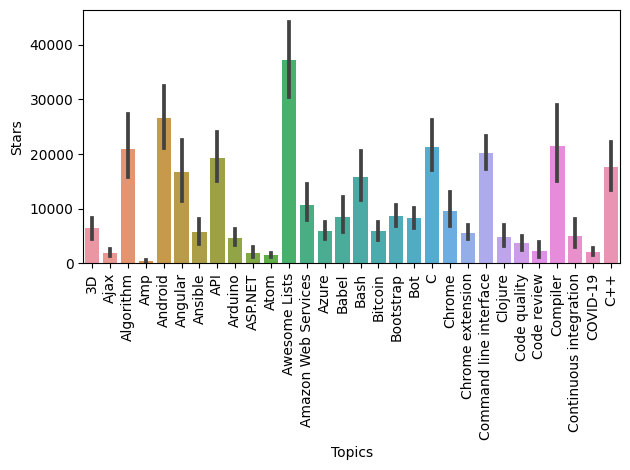

In [37]:
#finding which topic in the data has the most stars

topics = first_clean_df["Topics"]

sns.barplot(data=first_clean_df, x="Topics", y="Stars")
plt.xticks(rotation=90)
plt.tight_layout()

### project with greatest number of stars involve awesome lists

### mow let's investigate which project gets the most forks

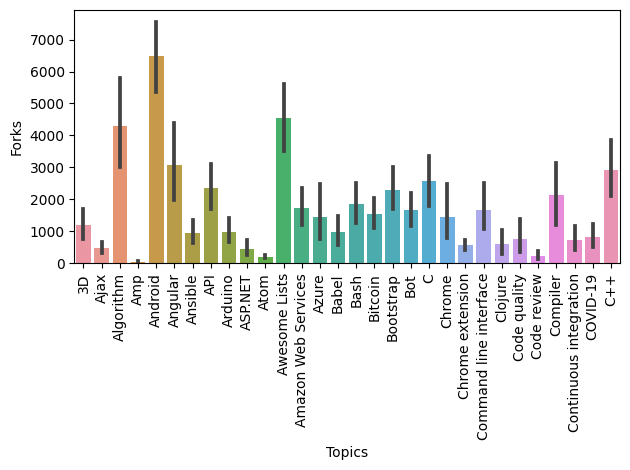

In [38]:

topics = first_clean_df["Topics"]

sns.barplot(data=first_clean_df, x="Topics", y="Forks")
plt.xticks(rotation=90)
plt.tight_layout()

##### the projects twith the greatestnumber of forks seems seem to be theones with the 'android' topic.

# Implementing the classification algorithm

In [39]:
#let's define some constants that will help us later on
column_names = ["Stars", "Issues", "Pull_Requests", 'Forks', "Topics"]

topics = ['3D', 'Ajax', 'Algorithm', 'Amp', 'Android', 'Angular', 'Ansible', 'API',
        'Arduino', 'ASP.NET', 'Atom', 'Awesome Lists', 'Amazon Web Services', 'Azure',
        'Babel', 'Bash', 'Bitcoin', 'Bootstrap', 'Bot', 'C', 'Chrome',
        'Chrome extension', 'Command line interface', 'Clojure', 'Code quality',
        'Code review', 'Compiler', 'Continuous integration', 'COVID-19', 'C++']


numerical_columns = ["Stars", "Forks", "Issues"  ,"Pull_Requests"]
categorical_columns=["Topics"]

#### encoding data and preparing the Training vs testing datasets

In [40]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [45]:
first_clean_df.head()

,Stars,Issues,Pull_Requests,Forks,Topics
1,19600,164.0,61,6300,3D
2,16800,18.0,4,908,3D
3,15900,72.0,11,2700,3D
4,13800,310.0,39,3300,3D
5,12100,26.0,0,1200,3D


##### encoding the categorical feature column 

In [46]:
#first encode the categorical columns
encoder = LabelEncoder()
first_clean_df['Topics']= encoder.fit_transform(first_clean_df['Topics'])


feature_columns=[]

for feature in numerical_columns:
    feature_columns.append(tf.feature_column.numeric_column(feature, dtype=tf.float32))

print(feature_columns)
first_clean_df.head(20)


[NumericColumn(key='Stars', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Forks', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Issues', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Pull_Requests', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


C:\Users\amilc\AppData\Local\Temp\ipykernel_23832\2785463303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_clean_df['Topics']= encoder.fit_transform(first_clean_df['Topics'])


,Stars,Issues,Pull_Requests,Forks,Topics
1,19600,164.0,61,6300,0
2,16800,18.0,4,908,0
3,15900,72.0,11,2700,0
4,13800,310.0,39,3300,0
5,12100,26.0,0,1200,0
6,12100,13.0,0,907,0
7,10700,734.0,67,2600,0
8,900,38.0,6,350,0
9,8300,1200.0,28,2700,0
10,7600,16.0,2,1600,0


##### defining the input function that will feed the data to the model

In [47]:
#define an imput function that will shuffle and feed data in batches to our model

def make_input(data_df, label_df, num_epochs=15, shuffle=True, batch_size=32):
    def input_function():
        data_set = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))#create a tf data.dataset object with data and its labels
        if shuffle:
            data_set=data_set.shuffle(1000)#shuffle data
        data_set = data_set.batch(batch_size).repeat(num_epochs) #split dataset into batches of 32 and repeat process for num of epochs
        return data_set #return a batch of the dataset
    return input_function

#### splitting the data in training and testing parts

In [48]:
#splitting the data in trianing and testing data:
X = first_clean_df.drop('Topics', axis=1)
y = first_clean_df["Topics"]
dX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [52]:
train_input_function = make_input(dX_train, y_train) #call the input function that was returned to us to get a dataset object
eval_input_function = make_input(X_test, y_test, num_epochs=1, shuffle=False) #this is testing data os model only needs to see the testing data once

linear_estinmator=tf.estimator.LinearClassifier(feature_columns=feature_columns, n_classes=30)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\amilc\\AppData\\Local\\Temp\\tmp1_lhqsgq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [53]:
linear_estinmator.train(train_input_function) #train \ above error results because you defined the feature columns and then removed Topics from the training dataset
result = linear_estinmator.evaluate(eval_input_function)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\amilc\AppData\Local\Temp\tmp1_lhqsgq\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 3.4011974, step = 0
INFO:tensorflow:global_step/sec: 510.982
INFO:tensorflow:loss = 279.21313, step = 100 (0.197 sec)
INFO:tensorflow:global_step/sec: 592.93
INFO:tensorflow:loss = 180.85342, step = 200 (0.173 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 270...
INFO:tensorflow:Saving checkpoints for 270 into C:\Users\amilc\AppData\Local\Temp\tmp1_lhqsgq\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 270...
INFO:tensorfl

In [54]:
print(result)

{'accuracy': 0.06049822, 'average_loss': 329.37546, 'loss': 328.70786, 'global_step': 270}
